# Examples and Exercises from Think Stats, 2nd Edition

http://thinkstats2.com

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT


In [66]:
from __future__ import print_function, division

%matplotlib inline

import numpy as np

import thinkstats2
import thinkplot

## Exercises

The distribution of income is famously skewed to the right. In this exercise, we’ll measure how strong that skew is.
The Current Population Survey (CPS) is a joint effort of the Bureau of Labor Statistics and the Census Bureau to study income and related variables. Data collected in 2013 is available from http://www.census.gov/hhes/www/cpstables/032013/hhinc/toc.htm. I downloaded `hinc06.xls`, which is an Excel spreadsheet with information about household income, and converted it to `hinc06.csv`, a CSV file you will find in the repository for this book. You will also find `hinc2.py`, which reads this file and transforms the data.

The dataset is in the form of a series of income ranges and the number of respondents who fell in each range. The lowest range includes respondents who reported annual household income “Under \$5000.” The highest range includes respondents who made “\$250,000 or more.”

To estimate mean and other statistics from these data, we have to make some assumptions about the lower and upper bounds, and how the values are distributed in each range. `hinc2.py` provides `InterpolateSample`, which shows one way to model this data. It takes a `DataFrame` with a column, `income`, that contains the upper bound of each range, and `freq`, which contains the number of respondents in each frame.

It also takes `log_upper`, which is an assumed upper bound on the highest range, expressed in `log10` dollars. The default value, `log_upper=6.0` represents the assumption that the largest income among the respondents is $10^6$, or one million dollars.

`InterpolateSample` generates a pseudo-sample; that is, a sample of household incomes that yields the same number of respondents in each range as the actual data. It assumes that incomes in each range are equally spaced on a `log10` scale.

In [67]:
def InterpolateSample(df, log_upper=7.0):
    """Makes a sample of log10 household income.

    Assumes that log10 income is uniform in each range.

    df: DataFrame with columns income and freq
    log_upper: log10 of the assumed upper bound for the highest range

    returns: NumPy array of log10 household income
    """
    # compute the log10 of the upper bound for each range
    df['log_upper'] = np.log10(df.income)

    # get the lower bounds by shifting the upper bound and filling in
    # the first element
    df['log_lower'] = df.log_upper.shift(1)
    df.loc[0, 'log_lower'] = 3.0

    # plug in a value for the unknown upper bound of the highest range
    df.loc[41, 'log_upper'] = log_upper
    
    # use the freq column to generate the right number of values in
    # each range
    arrays = []
    for _, row in df.iterrows():
        vals = np.linspace(row.log_lower, row.log_upper, int(row.freq))
        arrays.append(vals)

    # collect the arrays into a single sample
    log_sample = np.concatenate(arrays)
    return log_sample


In [68]:
import hinc
income_df = hinc.ReadData()

In [69]:
log_sample = InterpolateSample(income_df, log_upper=7.0)
type(log_sample)

numpy.ndarray

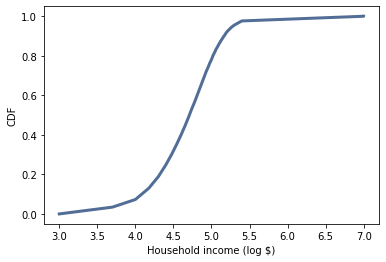

In [70]:
log_cdf = thinkstats2.Cdf(log_sample)
thinkplot.Cdf(log_cdf)
thinkplot.Config(xlabel='Household income (log $)',
               ylabel='CDF')

In [71]:
sample = np.power(10, log_sample)
type(sample)

numpy.ndarray

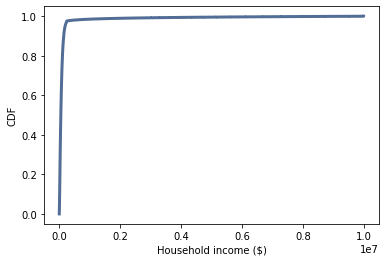

In [72]:
cdf = thinkstats2.Cdf(sample)
thinkplot.Cdf(cdf)
thinkplot.Config(xlabel='Household income ($)',
               ylabel='CDF')

Compute the median, mean, skewness and Pearson’s skewness of the resulting sample. What fraction of households report a taxable income below the mean? How do the results depend on the assumed upper bound?

# Results with log_upper=6
median 51226.4544789
mean 74278.7075312
std 93946.9299634784
skewness 4.94992024443
pearson skewness 0.736125801914

The mean is greater than the median so the distribution skews right.


# Results with log_upper=7 (10 million)
median 51226.4544789
mean 124267.39722164693
std 559608.5013743476
skewness 11.603690267537795
pearson skewness 0.39156450927742104

Here we see that the median stays the same but the mean is greater than the median so the distribution skews right.

So with a higher upper bound, the moment-based skewness increases, as expected.  But the Pearson skewness goes down. The reason seems to be that increasing the upper bound has a modest effect on the mean, and a stronger effect on standard deviation.  Since std is in
the denominator with exponent 3, it has a stronger effect on the result.

So this is apparently an example where Pearson skewness is not working well as a summary statistic.

In [65]:
# This is when the highest salary is $1 million
# What fraction of households report taxable income below the mean?
### Ans is 50%

# scipy.stats.norm represents a normal distribution
import scipy.stats
mean = 74278.7075312
std = 93946.9299634784
dist = scipy.stats.norm(loc=mean, scale=std)

dist.cdf(mean)

0.5

In [81]:
# This is when the highest salary is $10 million
# What fraction of households report taxable income below the mean?
### Ans is 50%

# scipy.stats.norm represents a normal distribution
import scipy.stats
mean = 124267.39722164693
std = 559608.5013743476
dist = scipy.stats.norm(loc=mean, scale=std)

dist.cdf(mean)

0.5

In [73]:
def Median(xs):
    cdf = thinkstats2.Cdf(xs)
    return cdf.Value(0.5)

Median(sample)

51226.45447894046

In [74]:
# Solution goes here
# Raw moments are just sums of powers.
def RawMoment(xs, k):
    return sum(x**k for x in xs) / len(xs)

In [75]:
# The first raw moment is the mean.
def Mean(xs):
    return RawMoment(xs, 1)

Mean(sample)

124267.39722164693

In [76]:
# Solution goes here
# The central moments are powers of distances from the mean.
def CentralMoment(xs, k):
    mean = RawMoment(xs, 1)
    return sum((x - mean)**k for x in xs) / len(xs)

In [77]:
# The standardized moments are ratios of central moments, with powers chosen to make the dimensions cancel.
def StandardizedMoment(xs, k):
    var = CentralMoment(xs, 2)
    std = np.sqrt(var)
    return CentralMoment(xs, k) / std**k

In [78]:
def StandardDeviation(xs):
    var = CentralMoment(xs, 2)
    return np.sqrt(var)
 
StandardDeviation(sample)

559608.5013743476

In [79]:
# The third standardized moment is skewness.
def Skewness(xs):
    return StandardizedMoment(xs, 3)

Skewness(sample)

11.603690267537795

In [80]:
# Solution goes here
def PearsonMedianSkewness(xs):
    median = Median(xs)
    mean = RawMoment(xs, 1)
    var = CentralMoment(xs, 2)
    std = np.sqrt(var)
    gp = 3 * (mean - median) / std
    return gp

PearsonMedianSkewness(sample)

0.39156450927742104

All of this is based on an assumption that the highest income is one million dollars, but that's certainly not correct.  What happens to the skew if the upper bound is 10 million?

Without better information about the top of this distribution, we can't say much about the skewness of the distribution.